# How to perform aperture photometry with custom apertures?

We have discussed in [previous tutorials](http://lightkurve.keplerscience.org/tutorials/1.03-what-are-lightcurves.html) how Simple Aperture Photometry works. We choose a set of pixels in the image and sum those to produce a single flux value. We do this for every image as a function of time to produce a light curve.

The [Kepler Data Pipeline](https://github.com/nasa/kepler-pipeline) produces an aperture, which is used by default by lightkurve. However, there are some cases where you might want to produce your own aperture. The field may be crowded, or you may wish to change the aperture size to change the relative contribution of the background. We can do this simply with lightkurve.

First, let's load a target pixel file. Let's choose [KIC 6679295](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=KOI-2862.01&type=KEPLER_CANDIDATE). This is a Kepler planet canidate. We'll use the `from_archive` function to download every target pixel file available for each quarter of this data set. 

In [1]:
%%capture
from lightkurve import search_targetpixelfile
import matplotlib.pyplot as plt
%matplotlib inline
kic = '6679295'

tpfs = search_targetpixelfile(kic).download_all()

We've now created a list of `KeplerTargetPixelFiles`, where each item is a different quarter. We're going to be able to combine these just like in the [stitching tutorial](). 

Let's take a look at just one of those target pixel files.

In [2]:
#Build the light curve
pipeline_lc = tpfs[0].to_lightcurve().flatten()
for tpf in tpfs:
    pipeline_lc = pipeline_lc.append(tpf.to_lightcurve().flatten())
    
#Clean the light curve
pipeline_lc = pipeline_lc.remove_nans().remove_outliers()

Above we have created the light curve from the target pixel files, stitched them all together in the same way as in the [stitching tutorial] using lightkurves `append` function. To recap the steps we:

* Convert to a `KeplerLightCurve` object with `to_lightcurve()`
* Remove NaNs with `remove_nans()`
* Remove long term trends with `flatten()`
* Remove outliers with simple sigma clipping using `remove_outliers()`

The period for this planet candidate is 24.57537 days. Let's plot it up and take a look.

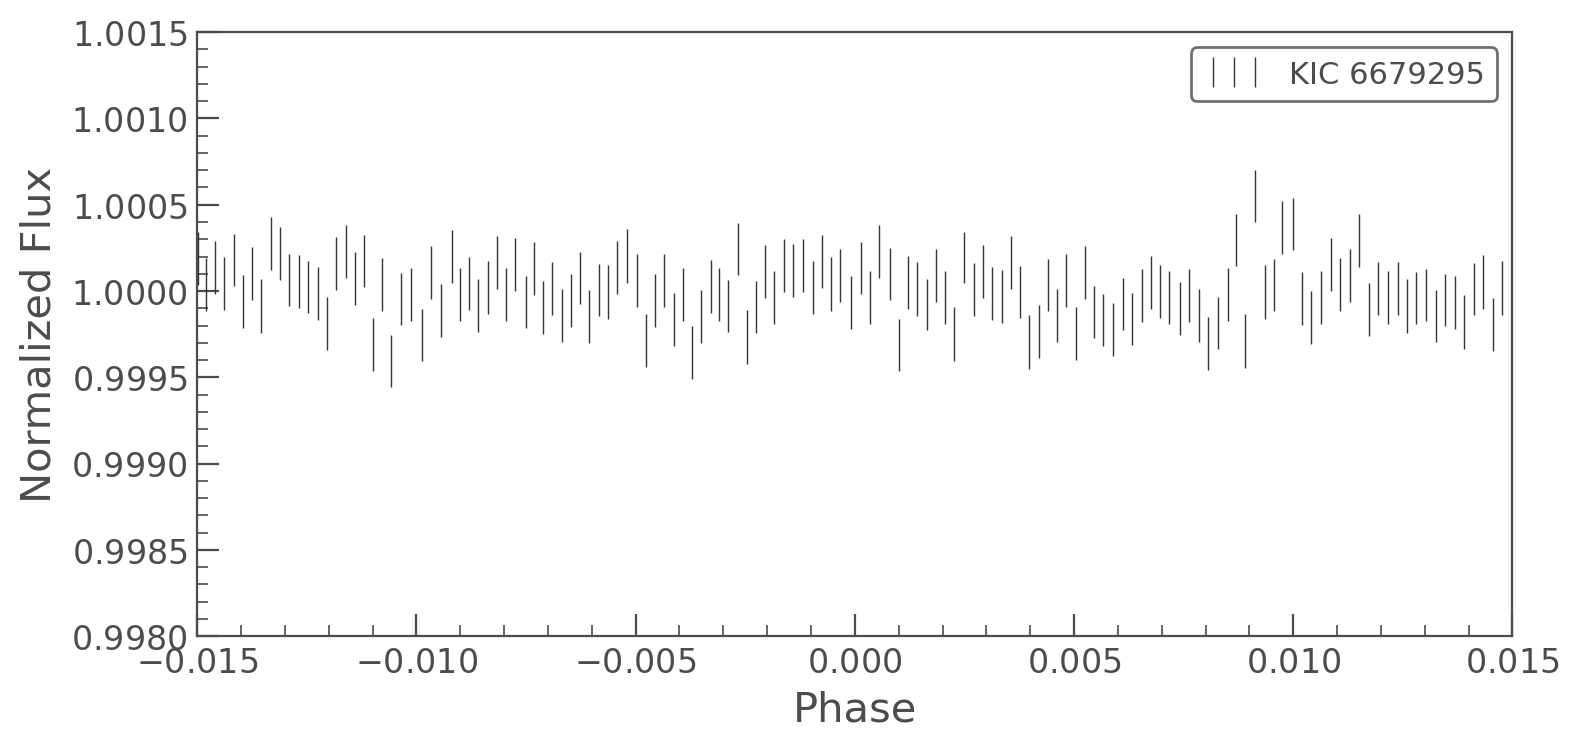

In [3]:
pipeline_lc.fold(period=24.57537, transit_midpoint=-0.133).bin().errorbar()
plt.xlim(-0.015,0.015)
plt.ylim(0.998,1.0015);

Looks like a great candidate. However, we might just want to check on the pixels. Let's plot one of the target pixel files.

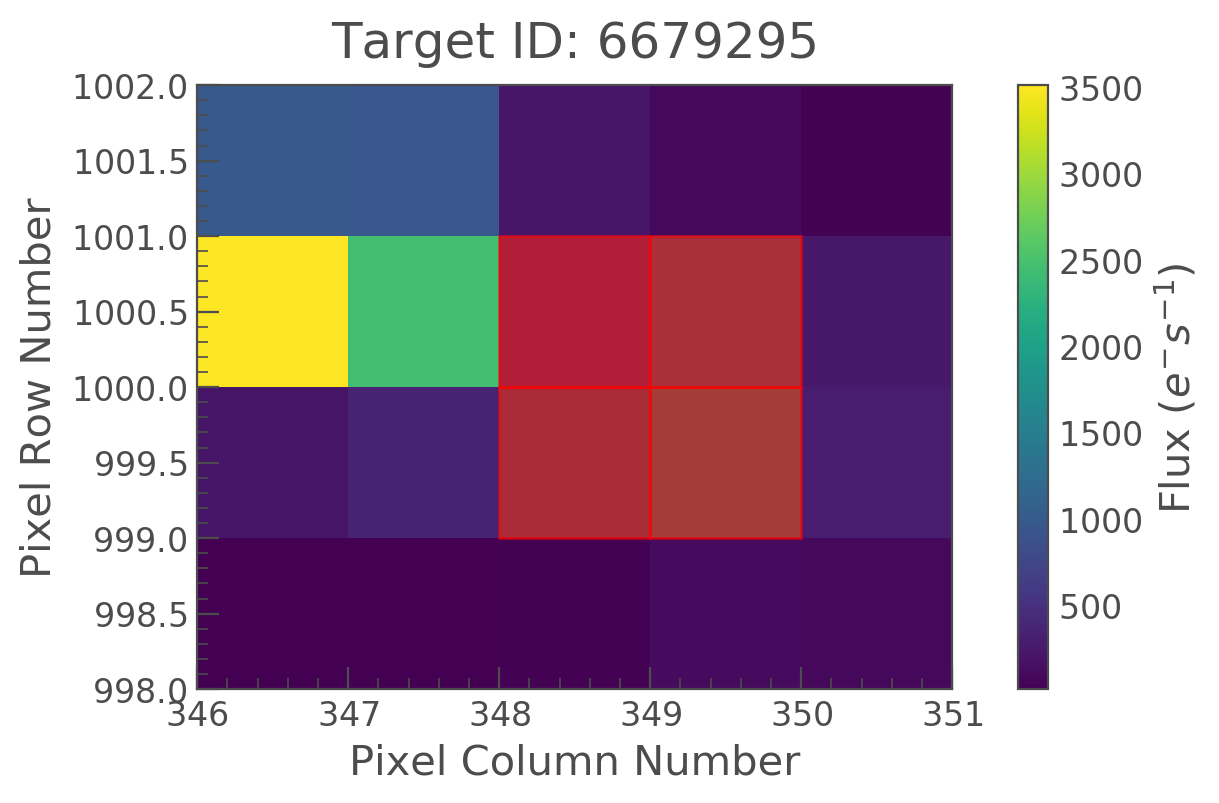

In [4]:
tpf.plot(frame=100, aperture_mask=tpf.pipeline_mask, mask_color='red');

The Kepler Pipeline aperture is in red. It looks like there is a nearby contaminate star! We might want to check that the signal is not really coming from the bright, nearby contaminant, rather than our target star. Let's use the top right corner four pixels as our new mask.

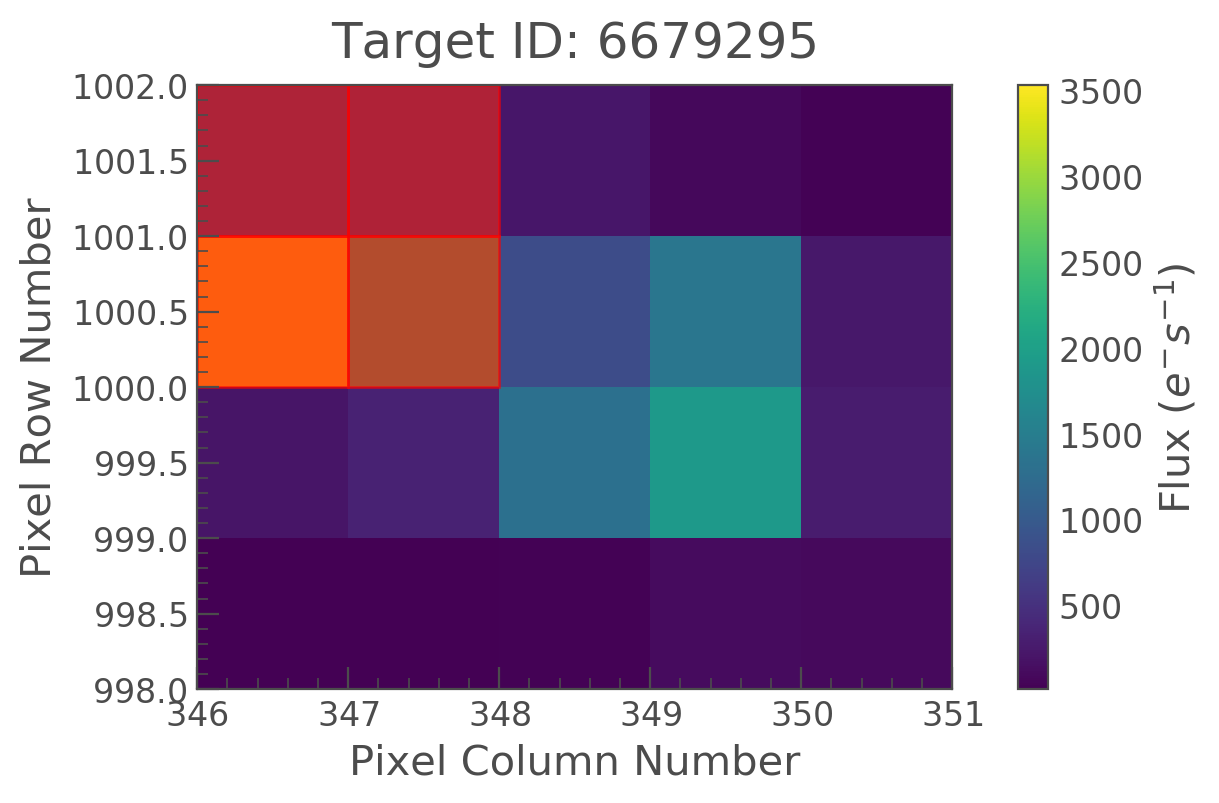

In [5]:
import numpy as np
aper = np.zeros(tpf.shape[1:], dtype=np.int)
aper[-2:, 0:2] = 1
tpf.plot(aperture_mask=aper, mask_color='red');

The new mask covers the bright star. Now we can iterate through the target pixel files and build the light curve in the same way as before, but this time 

In [6]:
#Build the NEW aperture, and the light curve
aper = np.zeros(tpfs[0].shape[1:])
aper[-2:, 0:2] = 1
user_lc = tpfs[0].to_lightcurve(aperture_mask=aper.astype(bool)).flatten()
for tpf in tpfs:
    aper = np.zeros(tpf.shape[1:])
    aper[-2:, 0:2]=1
    user_lc = user_lc.append(tpf.to_lightcurve(aperture_mask=aper.astype(bool)).flatten())

#Clean the light curve
user_lc = user_lc.remove_nans().remove_outliers()

Now we have our new light curve we can plot it up again and find out if there is still a planet signal.

(0.998, 1.0015)

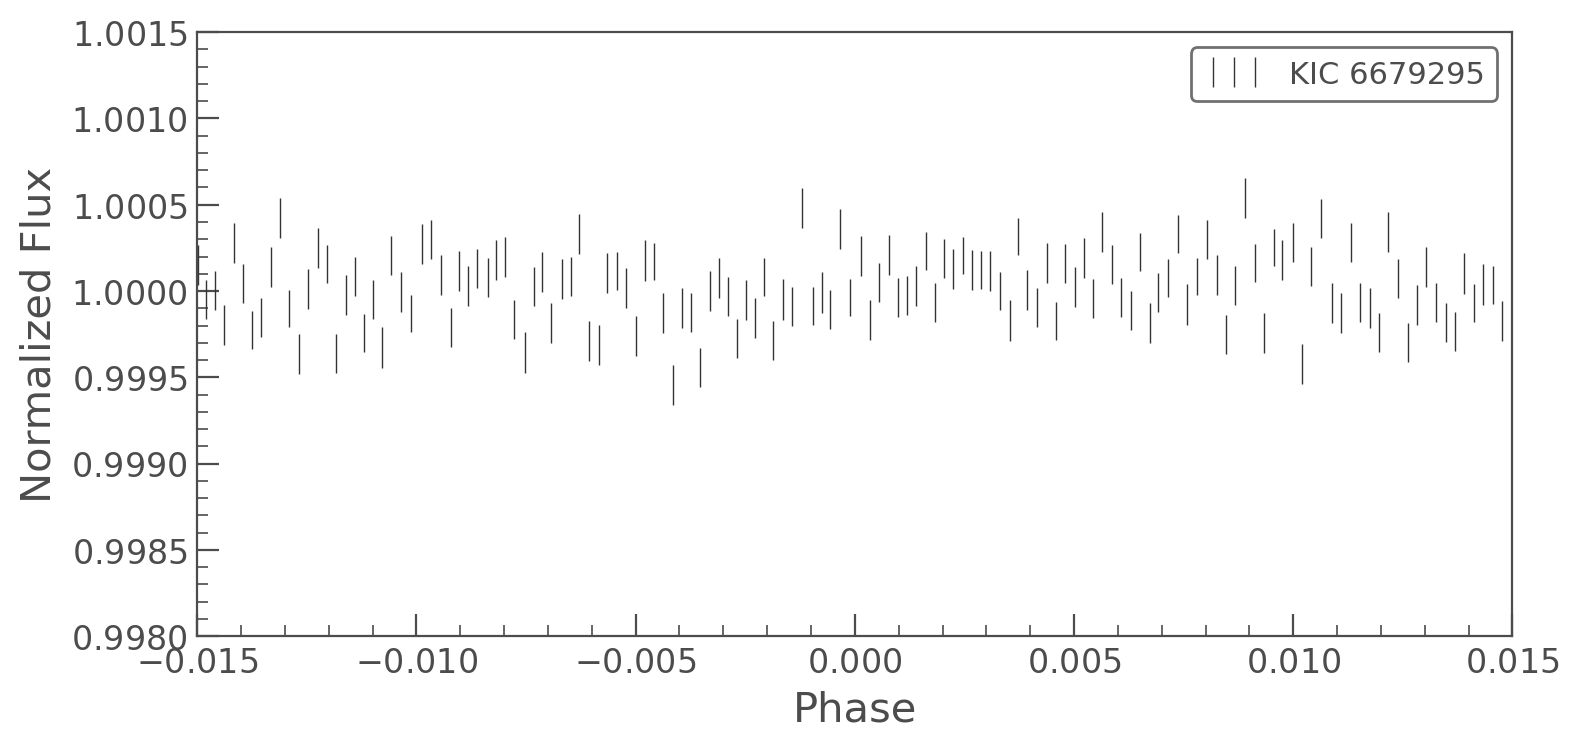

In [7]:
user_lc.fold(period=24.57537, transit_midpoint=-0.133).bin().errorbar();
plt.xlim(-0.015,0.015)
plt.ylim(0.998,1.0015)

Looks like the planet signal is only in the target star and doesn't belong to the contaminant. This is just one of many checks you might want to perform to validate your planet candidates!